In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
assets = ['BTC-USD', 'ETH-USD']

In [3]:
price_data = yf.download(" ".join(assets), start='2022-12-22', end='2022-12-23',  interval = '1m')

[*********************100%***********************]  2 of 2 completed


In [4]:
adjclose = price_data['Adj Close']
adjclose

,BTC-USD,ETH-USD
Datetime,,
2022-12-22 00:00:00,16818.380859,1213.672607
2022-12-22 00:01:00,16825.763672,1214.051025
2022-12-22 00:02:00,16824.031250,1213.826782
2022-12-22 00:03:00,16829.160156,1214.177002
2022-12-22 00:04:00,16829.492188,1214.120728
...,...,...
2022-12-22 23:54:00,16829.533203,1218.223511
2022-12-22 23:55:00,16828.492188,1218.341797
2022-12-22 23:56:00,16829.121094,1218.353638


In [5]:
adjclose.describe()

,BTC-USD,ETH-USD
count,1434.000000,1434.000000
mean,16787.819817,1209.554313
std,78.957409,10.529552
min,16592.408203,1187.127808
25%,16774.078125,1210.712860
50%,16824.439453,1214.487244
75%,16843.060547,1216.541901
max,16866.673828,1221.986816


In [6]:
price_data['Open'].iloc[0]

BTC-USD    16818.380859
ETH-USD     1213.672607
Name: 2022-12-22 00:00:00, dtype: float64

In [7]:
adjclose.iloc[-1]

BTC-USD    16829.089844
ETH-USD     1218.134766
Name: 2022-12-22 23:58:00, dtype: float64

In [8]:
lr1 = np.log(adjclose.iloc[:, 0] / adjclose.iloc[:, 0].shift(1))[1:]
lr2 = np.log(adjclose.iloc[:, 1] / adjclose.iloc[:, 1].shift(1))[1:]
mu_1 = lr1.mean() * 1434
mu_2 = lr2.mean() * 1434
sigma_1 = lr1.std() * np.sqrt(1434)
sigma_2 = lr2.std() * np.sqrt(1434)
rho = lr1.corr(lr2)
z_0 = 0.00
gamma = 0.5
delta = 0.8
T = 1
M = len(adjclose)
print(f'{M=}, {mu_1=}, {mu_2=}, {sigma_1=}, {sigma_2=},{rho=}')

M=1434, mu_1=0.0006369844529360043, mu_2=0.0036723937280563773, sigma_1=0.007598831208090518, sigma_2=0.014319298259977598,rho=0.8621801621939549


In [9]:
result = linregress(np.log(adjclose.iloc[:, 0]), np.log(adjclose.iloc[:, 1]))
beta = result.slope
beta

1.771247519213032

In [10]:
S1_0 = price_data['Open'].iloc[:, 0][0] # opening price for BTC
S2_0 = price_data['Open'].iloc[:, 1][0] # opening price for ETH
print(f'{S1_0=}, {S2_0=}')


S1_0=16818.380859375, S2_0=1213.672607421875


In [11]:
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [12]:
dt = T/M

In [13]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = adjclose.iloc[:, 0][t-1]
    S2[t] = adjclose.iloc[:, 1][t-1]

In [14]:
colors = ['m', 'y']
font = {'family': 'sans-serif',
        'color':  'b',
        'weight': 'bold',
        'size': 16,
        }

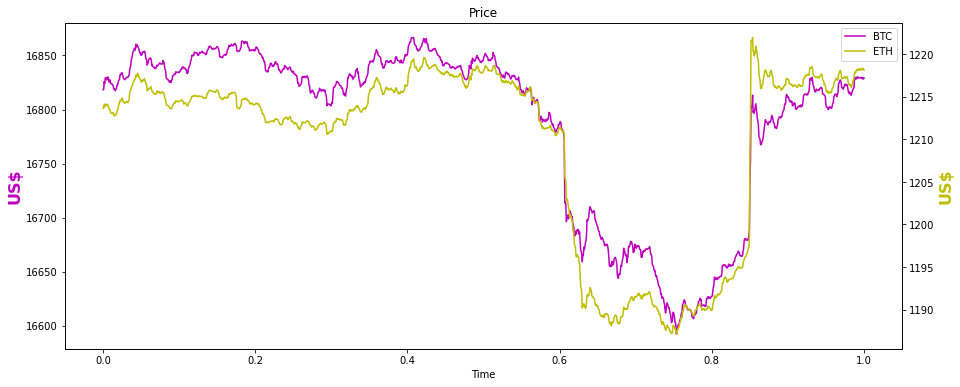

In [15]:
labels = [c.replace('-USD','').replace('.SW','') for c in adjclose.columns]
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(tt, S1, colors[0], lw=1.5, label=labels[0])
lns2 = ax2.plot(tt, S2, colors[1], lw=1.5, label=labels[1])
ax1.set_xlabel('Time')
ax1.set_ylabel('US$',fontdict=font, color=colors[0])
ax2.set_ylabel('US$',fontdict=font, color=colors[1])

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc=0)

plt.title('Price')
plt.show()

Text(0.5, 1.0, 'z')

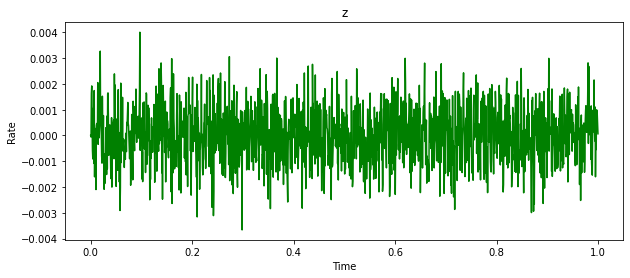

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

In [17]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

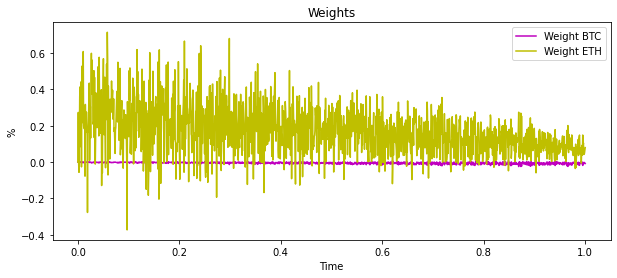

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(tt, Pi_1, colors[0], lw=1.5, label=f'Weight {labels[0]}')
plt.plot(tt, Pi_2, colors[1], lw=1.5, label=f'Weight {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash process')

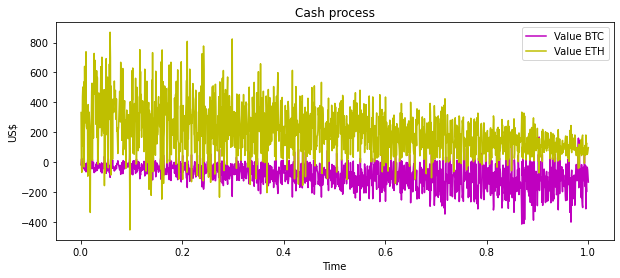

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], Pi_1[1:]*S1[1:], colors[0], lw=1.5, label=f'Value {labels[0]}')
plt.plot(tt[1:], Pi_2[1:]*S2[1:], colors[1], lw=1.5, label=f'Value {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Cash process')

In [20]:
wealth_dynamic = np.abs(Pi_1)*S1+np.abs(Pi_2)*S2

Text(0.5, 1.0, 'Wealth')

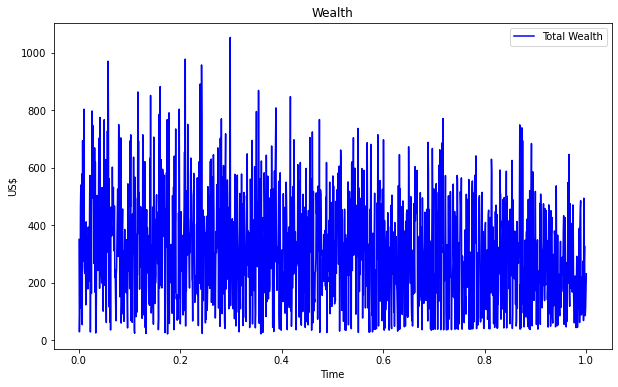

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], wealth_dynamic[1:], 'b', lw=1.5, label='Total Wealth')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Wealth')

In [22]:
wealth_static = np.mean(Pi_1)*S1+np.mean(Pi_2)*S2

Text(0.5, 1.0, 'Total Wealth')

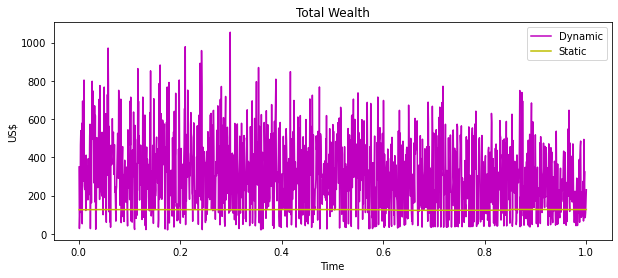

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], wealth_dynamic[1:], colors[0], lw=1.5, label='Dynamic')
plt.plot(tt[1:], wealth_static[1:], colors[1], lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Total Wealth')

In [24]:
dyn_return = 100*(wealth_dynamic[-1]/wealth_dynamic[1] - 1)
f'{float(dyn_return):.2f}%'

'-34.06%'

In [25]:
stat_return = 100*(wealth_static[-1]/wealth_static[1] -1)
f'{float(stat_return):.2f}%'

'0.56%'

In [26]:
lr1 = np.log(adjclose.iloc[:, 0] / adjclose.iloc[:, 0].shift(1))[1:] 
lr2 = np.log(adjclose.iloc[:, 1] / adjclose.iloc[:, 1].shift(1))[1:] 
rho = lr1.corr(lr2)
rho

0.8621801621939549

In [27]:
beta, z_inter, *_ = linregress(np.log(adjclose.iloc[:, 0]), np.log(adjclose.iloc[:, 1]))
beta

1.771247519213032

In [28]:
M = 1434                 
T = 1                     
dt = T/M                  
S1_0 = 16818.38               
S2_0 = 1213.67             
mu_1 = 0.0006396            
mu_2 = 0.0036877            
sigma_1 = 0.0076147         
sigma_2 = 0.01434922          
beta = 0.77124              
rho = 0.43109              
delta = 1                  
gamma = 0.6                

In [29]:
sS1 = np.zeros((M + 1, 1))
sS2 = np.zeros((M + 1, 1))
sz =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
sPi_1 = np.zeros((M + 1, 1))
sPi_2 = np.zeros((M + 1, 1))

In [30]:
tt = np.linspace(0, 1, M + 1)
sz[0] = z_0
sS1[0] = S1_0
sS2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(sz.shape)
rn1 = np.random.standard_normal(sS1.shape) 
rn2 = np.random.standard_normal(sS2.shape) 
for t in range(1, M + 1):
    sz[t] = z[t-1]* (1 - delta * (eta - sz[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    sS1[t] = sS1[t-1] * np.exp((mu_1 + delta * sz[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    sS2[t] = sS2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

In [31]:
colors = ['m', 'y']
font = {'family': 'sans-serif',
        'color':  'b',
        'weight': 'bold',
        'size': 16,
        }

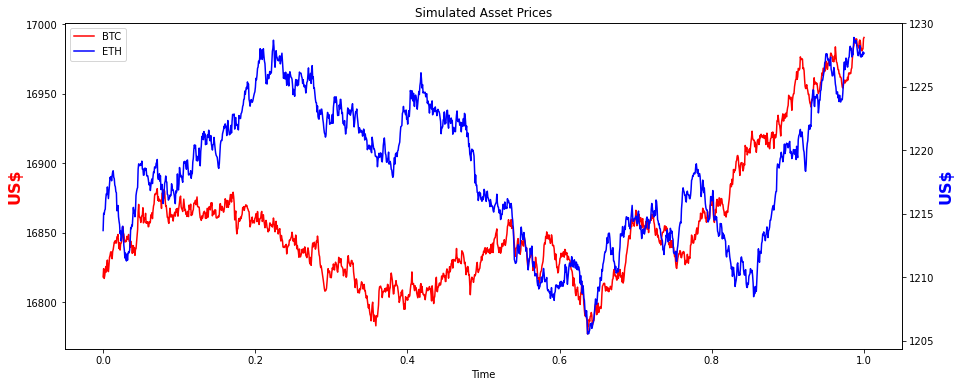

In [32]:
labels = [c.replace('-USD','') for c in adjclose.columns]
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(tt, sS1, 'r', lw=1.5, label=labels[0])
lns2 = ax2.plot(tt, sS2, 'b', lw=1.5, label=labels[1])
ax1.set_xlabel('Time')
ax1.set_ylabel('US$',fontdict=font, color='r')
ax2.set_ylabel('US$',fontdict=font, color='b')

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc=0)

plt.title('Simulated Asset Prices')
plt.show()

Text(0.5, 1.0, 'Simulated z')

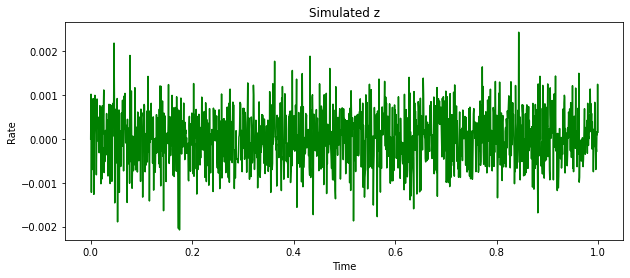

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(tt, sz, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Simulated z')


In [34]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    sPi_1[t] = (1 / sS1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    sPi_2[t] = (1 / sS2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * sz[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Simluated Weights')

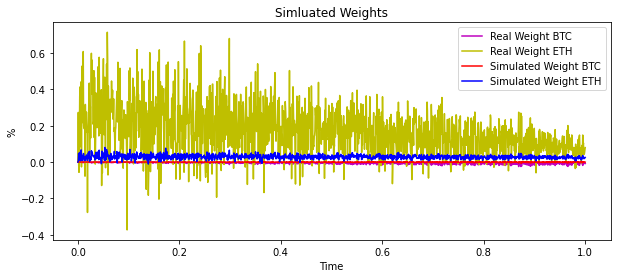

In [35]:
t_space = np.linspace(0, 1, len(Pi_1))
plt.figure(figsize=(10, 4))
plt.plot(t_space, Pi_1, colors[0], lw=1.5, label=f'Real Weight {labels[0]}')
plt.plot(t_space, Pi_2, colors[1], lw=1.5, label=f'Real Weight {labels[1]}')
plt.plot(tt, sPi_1, 'r', lw=1.5, label=f'Simulated Weight {labels[0]}')
plt.plot(tt, sPi_2, 'b', lw=1.5, label=f'Simulated Weight {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Simluated Weights')

Text(0.5, 1.0, 'Simluated Cash')

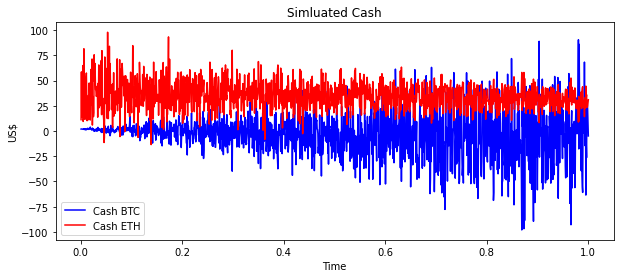

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], sPi_1[1:]*sS1[1:], 'b', lw=1.5, label=f'Cash {labels[0]}')
plt.plot(tt[1:], sPi_2[1:]*sS2[1:], 'r', lw=1.5, label=f'Cash {labels[1]}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Simluated Cash')

In [37]:
s_wealth_dynamic = np.abs(sPi_1)*sS1+np.abs(sPi_2)*sS2

Text(0.5, 1.0, 'Simulated Wealth')

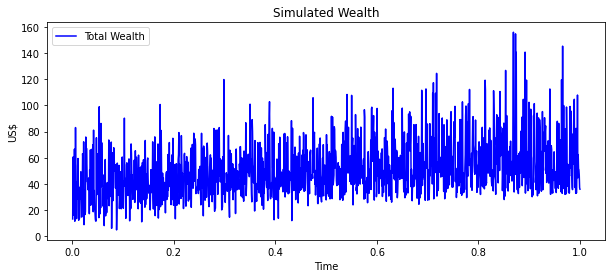

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(tt[1:], s_wealth_dynamic[1:], 'b', lw=1.5, label='Total Wealth')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Simulated Wealth')

In [39]:
s_wealth_static = np.mean(sPi_1)*sS1+np.mean(sPi_2)*sS2

Text(0.5, 1.0, 'Total Wealth')

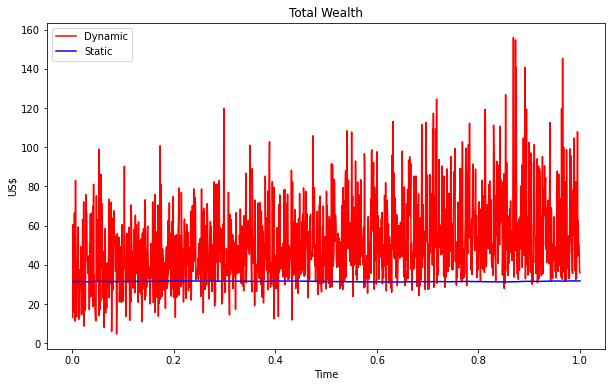

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], s_wealth_dynamic[1:], 'r', lw=1.5, label='Dynamic')
plt.plot(tt[1:], s_wealth_static[1:], 'b', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('US$')
plt.title('Total Wealth')

In [41]:
s_wealth_dynamic[-1]/s_wealth_dynamic[1] - 1

array([1.72784268])

In [42]:
s_wealth_static[-1]/s_wealth_static[1] - 1

array([0.01044733])